План рещения
1. Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)
2. Обучаем автоэнкодер на не_проливах (dataset\train)
3. Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.
4. В качестве loss функции используем MSE (как минимум для baseline)
5. Для определения порога используем изображения из dataset\proliv
6. Пишем метод классификации лунок
На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.


In [80]:
%%capture
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
replace dataset/proliv/10_CAM_C_01-03-2023_05-39-27-929.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%%capture
!pip install umap-learn wandb

In [3]:
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import pandas as pd
import tqdm
import umap
import wandb

import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Train

In [3]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        y, indices = self.mp(y)
        return y, indices


class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        y, indices = self.mp(y)
        return y, indices



class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices):
        y = self.mup(x, indices)
        y = self.seq(y)
        return y


class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices):
        y = self.mup(x, indices)
        y = self.seq(y)
        return y


class SegNet(torch.nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size=kernel_size)


        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size=kernel_size)
        self.uc1 = UpConv2(64, 3, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # SegNet Encoder
        x, mp1_indices = self.dc1(x)
        x, mp2_indices = self.dc2(x)
        x, mp3_indices = self.dc3(x)
        #x, mp4_indices = self.dc4(x)

        emb = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        # SegNet Decoder
        #x = self.uc4(x, mp4_indices)
        x = self.uc3(x, mp3_indices)
        x = self.uc2(x, mp2_indices)
        x = self.uc1(x, mp1_indices)

        return x, emb


In [4]:
class ImageDataset(Dataset):
    def __init__(self,
                 dataset_dir: str,
                 img_size = (32, 32)
                 ):
        super(ImageDataset, self).__init__()

        self.root = dataset_dir
        self.dataset = os.listdir(dataset_dir)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=img_size),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def load_image(self, path):
        path = os.path.join(self.root, path)

        image = cv2.imread(path)
        image = self.transform(image)

        return image

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path = self.dataset[idx]
        image = self.load_image(path)

        return image



In [5]:
dataset = ImageDataset('dataset/train')

In [6]:
data = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=True)

In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="autoencoder",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "autoencoder",
    "epochs": 20,
    }
)

wandb: Currently logged in as: 412549 (notn3ss_team). Use `wandb login --relogin` to force relogin


In [8]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat, emb = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()

            wandb.log({'train_loss': loss.item()})
    return autoencoder

In [9]:
autoencoder = SegNet().to(device) # GPU

In [10]:
autoencoder_5 = train(autoencoder, data, epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2/2 [00:18<00:00,  9.02s/it]


In [11]:
autoencoder_5 = autoencoder_5.eval()

In [12]:
embs = []

with torch.no_grad():
  for i in range(len(dataset)):
    image = dataset[i].unsqueeze(0).to(device)
    output = autoencoder_5(image)[1]

    embs.append(output.cpu().numpy().squeeze(0))
    torch.cuda.empty_cache()

In [13]:
test_dataset = ImageDataset('/content/dataset/proliv')

In [14]:
test_embs = []

with torch.no_grad():
  for i in range(len(test_dataset)):
    image = test_dataset[i].unsqueeze(0).to(device)
    output = autoencoder_5(image)[1]

    test_embs.append(output.cpu().numpy().squeeze(0))
    torch.cuda.empty_cache()

In [15]:
part_1 = pd.DataFrame({'embeddings': embs, 'class': 0})
part_2 = pd.DataFrame({'embeddings': test_embs, 'class': 1})
df = pd.concat([part_1, part_2])

#Visualize

In [16]:
reducer = umap.UMAP(metric='euclidean', random_state=3)
reducer.fit(df['embeddings'].to_list())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=3, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [17]:
embedding = reducer.transform(df['embeddings'].to_list())
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(10154, 2)

In [18]:
df['color'] = df['class'].replace({0: 'blue', 1: 'red'})

<ipython-input-19-99034a046893>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], c=df.color, cmap='Spectral', s=5)


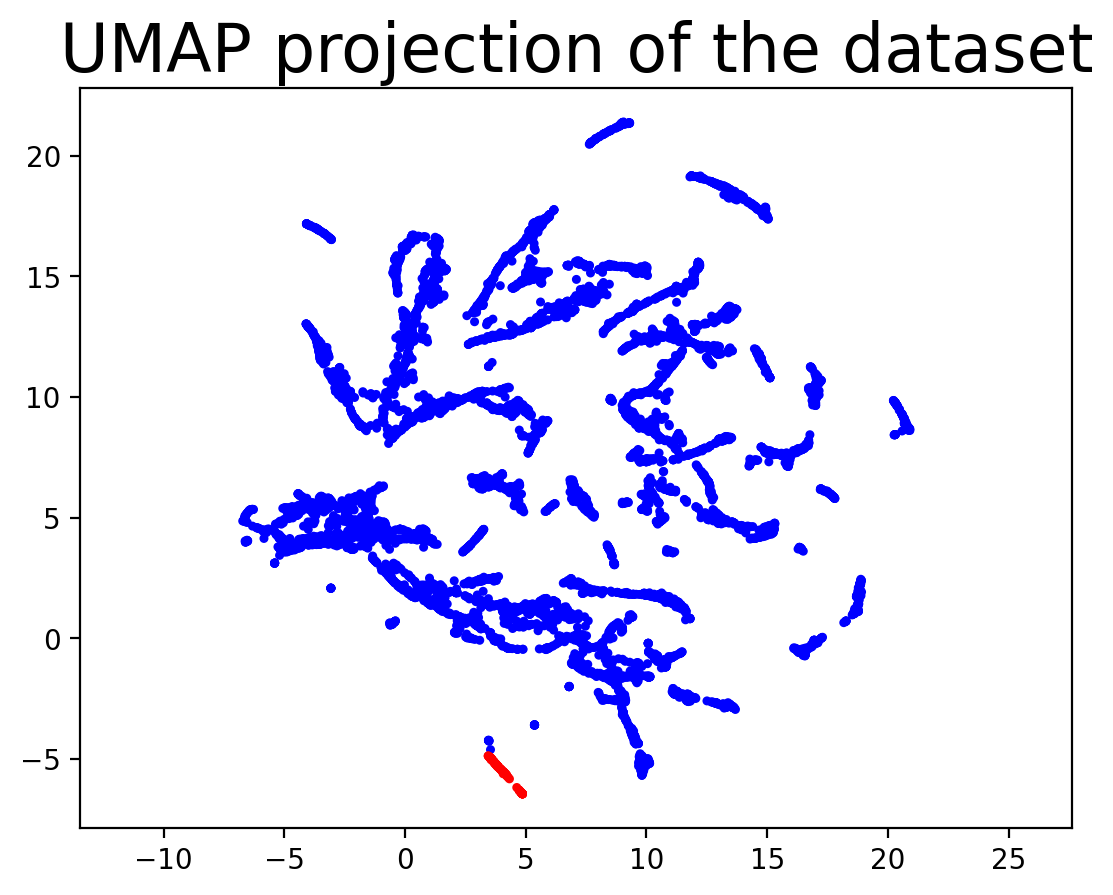

In [19]:
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1], c=df.color, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of the dataset', fontsize=24);

# Find threshold

In [20]:
def find_threshold(dataset, model):
    mse_list = list()
    with torch.no_grad():
        for i in range(len(dataset)):
            im = dataset[i].unsqueeze(0).to(device)
            out = model(im)[0]

            mse = ((im - out)**2).cpu().sum().item()

            mse_list.append(mse)

    return mse_list



In [21]:
mse_values = find_threshold(test_dataset, autoencoder_5)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [22]:
def get_score(image, model):
    with torch.no_grad():
      im = image.unsqueeze(0).to(device)
      out = model(im)[0]

      mse = ((im - out)**2).cpu().sum().item()

    return mse

In [23]:
eval_dataset = ImageDataset('/content/dataset/test/imgs')

In [24]:
annotations = {}
with open('/content/dataset/test/test_annotation.txt', 'r') as file:
    for line in file:
        image, label = line.split()
        annotations[image] = int(label)

In [25]:
def get_score_frame(dataset, model):
    output_list = list()

    for i in range(len(dataset)):
        path = dataset.dataset[i]
        image = dataset[i]

        pred = get_score(image, model)

        label = annotations[path]

        output_list.append({
            'path': path,
            'pred_score': pred,
            'label': label
        })

    return pd.DataFrame(output_list)


def tpr_tnr(df):
    tp = (df['label']==1)&(df['prediction']==1)
    fn = (df['label']==1)&(df['prediction']==0)
    tn = (df['label']==0)&(df['prediction']==0)
    fp = (df['label']==0)&(df['prediction']==1)

    return tp.sum() / (tp.sum() + fn.sum()), tn.sum() / (tn.sum() + fp.sum())


In [26]:
df = get_score_frame(eval_dataset, autoencoder_5)

In [27]:
def tptn_scores(df, mse_values):
    tp_list, tn_list, thresholds = list(), list(), list()

    for i in range(0, 100):
        thresh = np.percentile(mse_values, i)

        df['prediction'] = (df['pred_score'] > thresh).astype(int)

        tp, tn = tpr_tnr(df)

        tp_list.append(tp)
        tn_list.append(tn)
        thresholds.append(thresh)

    return tp_list, tn_list, thresholds


In [28]:
tp, tn, thresholds = tptn_scores(df, mse_values)

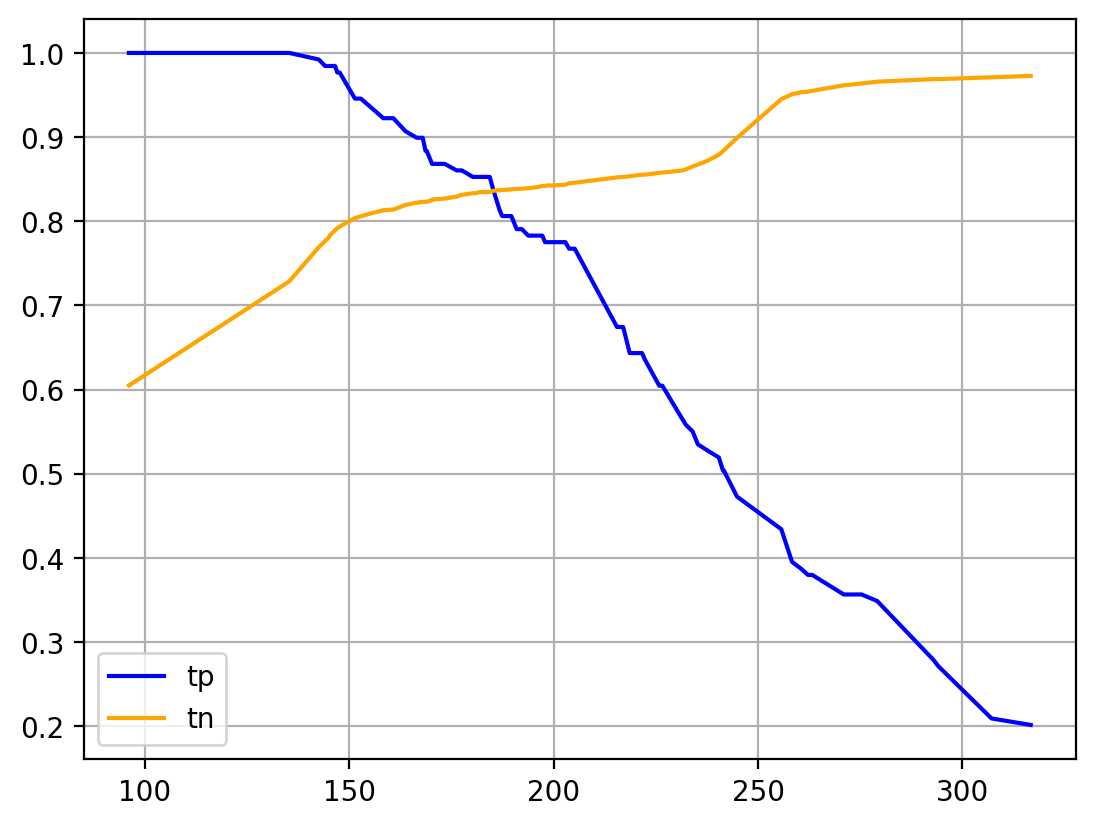

In [29]:
plt.plot(thresholds, tp, color='blue', label='tp')
plt.plot(thresholds, tn, color='orange', label='tn')
plt.grid()
plt.legend()

Оптимальный трешхолд, в первую очередь, зависит от бизнес-постановки (что для нас важнее - покрыть все, либо же минимизировать ложные срабатывания), в данном случае, следуя стратегии автоматического подбора оптимального трешхолда, я бы выбрала точку в которой линии пересекаются и равны примерно 0.8

In [34]:
threshold = thresholds[40]

In [36]:
df['prediction'] = (df['pred_score'] > threshold).astype(int)

In [37]:
print(classification_report(df['label'], df['prediction']))

              precision    recall  f1-score   support

           0       0.99      0.83      0.91      3665
           1       0.15      0.85      0.26       129

    accuracy                           0.84      3794
   macro avg       0.57      0.84      0.58      3794
weighted avg       0.97      0.84      0.89      3794



In [38]:
tpr_tnr(df)

(0.8527131782945736, 0.8346521145975443)